### DATA130051.01 计算机视觉 作业1
### 构建两层神经网络分类器
#### 牟婧翾 19307110508
Task introduction: Build a two-layer neural network and train it on the MNIST dataset, visualize the loss curves of training and testing, the accuracy curve of testing, and the network parameters of each layer.

In [10]:
import numpy as np
from numpy.random import randn
import random
import math
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import copy

#### 一、Model building
The model uses a two-layer neural network, with only one hidden layer for the input and output layers. The input data X undergoes a round of linear transformation and activation function, and then performs another linear transformation as new input data, and then the final output is obtained. The introduction of activation function can add nonlinear factors of the model, to some extent make up for the lack of expressive ability of the linear model. I chose the Sigmoid function as the activation function here, but the Sigmoid function also has shortcomings, such as: when the value obtained after linear transformation is very large or very small, its gradient will be very small, close to 0, which will lead to the calculation of gradient decreasing. The update of the gradient is very slow. After the forward propagation is completed, we get the predicted value of the classifier, and then use the square loss function to calculate the loss between the predicted value and the real value, and we can get the loss, and then according to the loss, we backpropagate step by step to make the gradient Calculate, update parameters, and train. During the training process, in order to make the classifier more accurate, we can use some methods and tricks.

##### 1 Learning rate descent strategy:

In the gradient descent algorithm, we need to specify a learning rate as a control factor for the weight update step. Common learning rates are 0.01, 0.001, and 0.0001, etc. The larger the learning rate, the faster the weight update. Generally speaking, we hope that the learning rate is larger in the early stage of training, so that the network converges quickly, and the learning rate is smaller in the later stage of training, so that the network can better converge to the optimal solution. Because if the learning rate is too large in the later stage, it is very likely that we will miss the optimal solution, or repeatedly jump around the optimal solution.

Here I use an exponential decay method, multiplying the learning rate by γ = 0.9 every five thousand iterations.

##### 2 L2 regularization：

Regularization methods refer to introducing additional information to the original loss function in order to prevent overfitting and improve model generalization performance.

I chose L2 regularization and used the two-norm of the weight as the penalty term of the loss function, which can promote the fitting process to favor the model with all parameters relatively small. Because it is generally considered that the model with small parameter value is relatively simple, it can adapt to different data sets, and it also avoids overfitting to a certain extent.

##### 3 Optimizer SGD：

SGD is an ordinary optimizer that randomly selects a sample as input to iterate the weights. Most of the time it is close to the global minimum, sometimes you will be far away from the minimum because the sample is pointing you in the wrong direction, so SGD has a lot of noise, on average, it will end up close to the minimum, but Sometimes it goes in the wrong direction too, so SGD never converges, but fluctuates around the minimum all the time.

Since SGD only processes one training sample at a time, the efficiency is too low. So I added mini-batch and selected data of mini-batch size to iterate, which is more efficient and converges faster.

In [11]:
def loss_L2(X, w1, w2, y, lambd):
    h = 1.0 / (1.0 + np.exp(-X.dot(w1)))  # 激活函数
    y_pred = h.dot(w2)
    loss = np.square(y_pred-y).sum()
    # L2正则化
    L2_regularization_cost = lambd * (np.sum(np.square(w1)) + np.sum(np.square(w2)))
    loss = loss + L2_regularization_cost  # loss计算
    # 反向传播及梯度计算
    dy_pred = 2.0*(y_pred-y)
    dw2 = h.T.dot(dy_pred) + lambd * w2 * 2.0
    dh = dy_pred.dot(w2.T)
    dw1 = X.T.dot(dh*h*(1-h)) + lambd * 2.0 * w1
    return loss, dw1, dw2

def predict(X, w1, w2):
    h = 1.0/(1.0+np.exp(-X.dot(w1)))
    y_pred = h.dot(w2)
    y_pred = (y_pred == y_pred.max(axis=1, keepdims=1)).astype(float)
    return y_pred


#### 二、parameter lookup
There are a large number of hyperparameters in neural network models, such as: learning rate, hidden layer size, regularization strength, weights, mini-batch size, learning rate decay γ, and so on. Therefore, parameter tuning is an essential step in neural networks. Next, I will sequentially adjust the hidden layer size, regularization strength, mini-batch, and learning rate. The method of parameter tuning I did not choose the grid method, but ignored the connection between the hyperparameters, found the best value one by one, and then combined it.

When looking for the size of the hidden layer, I used the most basic model, without adding regularization, the learning rate was also 1e-3, the learning rate candidates were from 50 to 150, and the difference between adjacent two was 10.

When looking for the regularization strength, I adjusted the number of hidden layers to the optimal number of layers obtained before, the learning rate was also 1e-3, and the regularization candidate strength was increased by a factor of 2, from 0.004 to 2.048.

When looking for mini-batch, I adjusted the number of hidden layers and regularization strength to the optimal number obtained before, and the learning rate was also 1e-3, and the number of mini-batch candidates was also increased by 2 times, from 1 to 64.

Finally, when looking for the learning rate, I adjusted the number of hidden layers, regularization strength, and mini-batch to the optimal numbers obtained before, and the learning rate was 1e-3, 1e-4, and 1e-5, respectively.

The following determines the parameter nhidden without regularization, that is, the hidden layer size:

In [10]:
def loss(X, w1, w2, y):
    h = 1.0 / (1.0 + np.exp(-X.dot(w1)))  # 激活函数
    y_pred = h.dot(w2)
    loss = np.square(y_pred-y).sum()
    # 反向传播及梯度计算
    dy_pred = 2.0*(y_pred-y)
    dw2 = h.T.dot(dy_pred)
    dh = dy_pred.dot(w2.T)
    dw1 = X.T.dot(dh*h*(1-h))
    return loss, dw1, dw2

if __name__ == "__main__":
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)  # MNIST_data指的是存放数据的文件夹路径，one_hot=True 为采用one_hot的编码方式编码标签
    # load data
    Xtrain = mnist.train.images  # 训练集样本
    Xvalid = mnist.validation.images  # 验证集样本
    Xtest = mnist.test.images  # 测试集样本
    # labels
    Ytrain = mnist.train.labels  # 训练集标签
    Yvalid = mnist.validation.labels  # 验证集标签
    Ytest = mnist.test.labels  # 测试集标签

    # shape参数
    n, d = Xtrain.shape
    t = Xvalid.shape[0]
    t2 = Xtest.shape[0]

    # 添加偏置项
    Xtrain = np.c_[np.ones(n), Xtrain]
    d = d + 1
    Xvalid = np.c_[np.ones(t), Xvalid]
    Xtest = np.c_[np.ones(t2), Xtest]

    # nLabels
    nLabels = 10
    
    train_error1 = []
    valid_error1 = []
    
    for lenHidden in range(50, 160, 10):
        random.seed(1)
        np.random.seed(1)
        # Choose network structure
        nHidden = np.array([lenHidden])

        # 随机确定初始w
        w1 = randn(d, nHidden[0])
        w2 = randn(nHidden[0], nLabels)

        # Train with stochastic gradient
        maxIter = 100000
        stepSize = 1e-3
        minibatch = 8
        gama = 0.9

        for iter in range(maxIter):
            if iter % round(maxIter / 20) == 0:
                stepSize = stepSize * gama  # 学习率下降策略
            # 优化器SGD
            i = [math.floor(random.random() * n) for k in range(minibatch)]
            l, dw1, dw2 = loss(Xtrain[i], w1, w2, Ytrain[i])
            w1 = w1 - stepSize * dw1
            w2 = w2 - stepSize * dw2

        yhat_train = predict(Xtrain, w1, w2)
        yhat_valid = predict(Xvalid, w1, w2)
        error1 = (yhat_train != Ytrain).sum() / n / 2.0
        error2 = (yhat_valid != Yvalid).sum() / t / 2.0
        train_error1.append(error1)
        valid_error1.append(error2)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


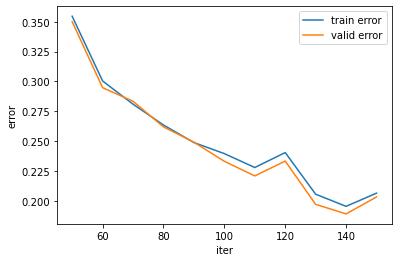

In [11]:
# 绘制error曲线
x = range(50,160,10)
plt.plot(x, train_error1, x, valid_error1)
plt.xlabel("iter")  # x轴上的名字
plt.ylabel("error")  # y轴上的名字
plt.legend(['train error', 'valid error'])
# new_ticks = np.linspace(0, 95000, 20)
# plt.xticks(new_ticks)
plt.show()

From the above figure, when the number of hidden layers is selected as 140, the error is low.

The following is to determine the parameter regularization strength, ie lamud:

In [16]:
def w_L2(X, w1, w2, y, lambd):
    h = 1.0 / (1.0 + np.exp(-X.dot(w1)))  # 激活函数
    y_pred = h.dot(w2)
    # 反向传播及梯度计算
    dy_pred = 2.0*(y_pred-y)
    dw2 = h.T.dot(dy_pred) + lambd * w2 * 2.0
    dh = dy_pred.dot(w2.T)
    dw1 = X.T.dot(dh*h*(1-h)) + lambd * 2.0 * w1
    return dw1, dw2

if __name__ == "__main__":
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)  # MNIST_data指的是存放数据的文件夹路径，one_hot=True 为采用one_hot的编码方式编码标签
    # load data
    Xtrain = mnist.train.images  # 训练集样本
    Xvalid = mnist.validation.images  # 验证集样本
    Xtest = mnist.test.images  # 测试集样本
    # labels
    Ytrain = mnist.train.labels  # 训练集标签
    Yvalid = mnist.validation.labels  # 验证集标签
    Ytest = mnist.test.labels  # 测试集标签

    # shape参数
    n, d = Xtrain.shape
    t = Xvalid.shape[0]
    t2 = Xtest.shape[0]

    # 添加偏置项
    Xtrain = np.c_[np.ones(n), Xtrain]
    d = d + 1
    Xvalid = np.c_[np.ones(t), Xvalid]
    Xtest = np.c_[np.ones(t2), Xtest]

    # nLabels
    nLabels = 10
    
    train_error1 = []
    valid_error1 = []
    
    for lamuda in [0.004,0.008,0.016,0.032,0.064,0.128,0.256,0.512,1.024,2.048]:
        random.seed(1)
        np.random.seed(1)
        # Choose network structure
        nHidden = np.array([140])

        # 随机确定初始w
        w1 = randn(d, nHidden[0])
        w2 = randn(nHidden[0], nLabels)

        # Train with stochastic gradient
        maxIter = 100000
        stepSize = 1e-3
        minibatch = 8
        gama = 0.9

        for iter in range(maxIter):
            if iter % round(maxIter / 20) == 0:
                stepSize = stepSize * gama  # 学习率下降策略
            # 优化器SGD
            i = [math.floor(random.random() * n) for k in range(minibatch)]
            dw1, dw2 = w_L2(Xtrain[i], w1, w2, Ytrain[i],lamuda)
            w1 = w1 - stepSize * dw1
            w2 = w2 - stepSize * dw2

        yhat_train = predict(Xtrain, w1, w2)
        yhat_valid = predict(Xvalid, w1, w2)
        error1 = (yhat_train != Ytrain).sum() / n / 2.0
        error2 = (yhat_valid != Yvalid).sum() / t / 2.0
        train_error1.append(error1)
        valid_error1.append(error2)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


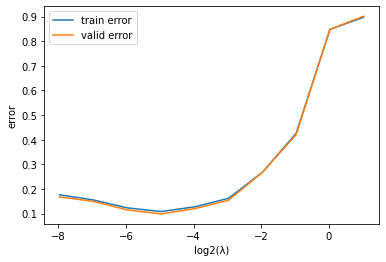

In [17]:
# 绘制error曲线
x = [0.004,0.008,0.016,0.032,0.064,0.128,0.256,0.512,1.024,2.048]
x = [math.log2(i) for i in x]
plt.plot(x, train_error1, x, valid_error1)
plt.xlabel("log2(λ)")  # x轴上的名字
plt.ylabel("error")  # y轴上的名字
plt.legend(['train error', 'valid error'])
# new_ticks = np.linspace(0, 95000, 20)
# plt.xticks(new_ticks)
plt.show()

From the above figure, when the number of λ is selected as 0.032, the error is low.

Next, determine the parameter minibatch:

In [35]:
def w_L2(X, w1, w2, y, lambd):
    h = 1.0 / (1.0 + np.exp(-X.dot(w1)))  # 激活函数
    y_pred = h.dot(w2)
    # 反向传播及梯度计算
    dy_pred = 2.0*(y_pred-y)
    dw2 = h.T.dot(dy_pred) + lambd * w2 * 2.0
    dh = dy_pred.dot(w2.T)
    dw1 = X.T.dot(dh*h*(1-h)) + lambd * 2.0 * w1
    return dw1, dw2

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)  # MNIST_data指的是存放数据的文件夹路径，one_hot=True 为采用one_hot的编码方式编码标签
# load data
Xtrain = mnist.train.images  # 训练集样本
Xvalid = mnist.validation.images  # 验证集样本
Xtest = mnist.test.images  # 测试集样本
# labels
Ytrain = mnist.train.labels  # 训练集标签
Yvalid = mnist.validation.labels  # 验证集标签
Ytest = mnist.test.labels  # 测试集标签

# shape参数
n, d = Xtrain.shape
t = Xvalid.shape[0]
t2 = Xtest.shape[0]

# 添加偏置项
Xtrain = np.c_[np.ones(n), Xtrain]
d = d + 1
Xvalid = np.c_[np.ones(t), Xvalid]
Xtest = np.c_[np.ones(t2), Xtest]

# nLabels
nLabels = 10

train_error1 = []
valid_error1 = []
for minibatch in [1,2,4,8,16,32,64]:
    random.seed(1)
    np.random.seed(1)
    # Choose network structure
    nHidden = np.array([140])

    # 随机确定初始w
    w1 = randn(d, nHidden[0])
    w2 = randn(nHidden[0], nLabels)

    # Train with stochastic gradient
    maxIter = 100000
    lamda = 0.032
    gama = 0.9
    stepSize = 0.001

    for iter in range(maxIter):
        if iter % round(maxIter / 20) == 0:
            stepSize = stepSize * gama  # 学习率下降策略
        # 优化器SGD
        i = [math.floor(random.random() * n) for k in range(minibatch)]
        dw1, dw2 = w_L2(Xtrain[i], w1, w2, Ytrain[i], lamda)
        w1 = w1 - stepSize * dw1
        w2 = w2 - stepSize * dw2
    
    yhat_train = predict(Xtrain, w1, w2)
    yhat_valid = predict(Xvalid, w1, w2)
    error1 = (yhat_train != Ytrain).sum() / n / 2.0
    error2 = (yhat_valid != Yvalid).sum() / t / 2.0
    train_error1.append(error1)
    valid_error1.append(error2)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


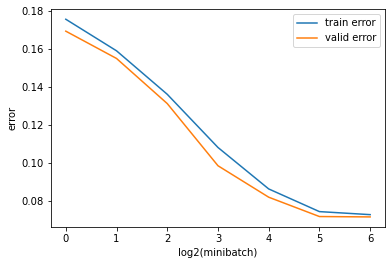

In [36]:
# 绘制error曲线
x = [1,2,4,8,16,32,64]
x = [math.log2(i) for i in x]
plt.plot(x, train_error1, x, valid_error1)
plt.xlabel("log2(minibatch)")  # x轴上的名字
plt.ylabel("error")  # y轴上的名字
plt.legend(['train error', 'valid error'])
# new_ticks = np.linspace(0, 95000, 20)
# plt.xticks(new_ticks)
plt.show()

From the above figure, when the number of minibatches is selected as 32, the error is lower and less.

The following is to determine the parameter learning rate, that is, stepsize:

In [38]:
def w_L2(X, w1, w2, y, lambd):
    h = 1.0 / (1.0 + np.exp(-X.dot(w1)))  # 激活函数
    y_pred = h.dot(w2)
    # 反向传播及梯度计算
    dy_pred = 2.0*(y_pred-y)
    dw2 = h.T.dot(dy_pred) + lambd * w2 * 2.0
    dh = dy_pred.dot(w2.T)
    dw1 = X.T.dot(dh*h*(1-h)) + lambd * 2.0 * w1
    return dw1, dw2

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)  # MNIST_data指的是存放数据的文件夹路径，one_hot=True 为采用one_hot的编码方式编码标签
# load data
Xtrain = mnist.train.images  # 训练集样本
Xvalid = mnist.validation.images  # 验证集样本
Xtest = mnist.test.images  # 测试集样本
# labels
Ytrain = mnist.train.labels  # 训练集标签
Yvalid = mnist.validation.labels  # 验证集标签
Ytest = mnist.test.labels  # 测试集标签

# shape参数
n, d = Xtrain.shape
t = Xvalid.shape[0]
t2 = Xtest.shape[0]

# 添加偏置项
Xtrain = np.c_[np.ones(n), Xtrain]
d = d + 1
Xvalid = np.c_[np.ones(t), Xvalid]
Xtest = np.c_[np.ones(t2), Xtest]

# nLabels
nLabels = 10

train_error1 = []
valid_error1 = []
for stepSize in [1e-3,1e-4, 1e-5]:
    random.seed(1)
    np.random.seed(1)
    # Choose network structure
    nHidden = np.array([140])

    # 随机确定初始w
    w1 = randn(d, nHidden[0])
    w2 = randn(nHidden[0], nLabels)

    # Train with stochastic gradient
    maxIter = 100000
    minibatch = 32
    lamda = 0.032
    gama = 0.9

    for iter in range(maxIter):
        if iter % round(maxIter / 20) == 0:
            stepSize = stepSize * gama  # 学习率下降策略
        # 优化器SGD
        i = [math.floor(random.random() * n) for k in range(minibatch)]
        dw1, dw2 = w_L2(Xtrain[i], w1, w2, Ytrain[i], lamda)
        w1 = w1 - stepSize * dw1
        w2 = w2 - stepSize * dw2
    
    yhat_train = predict(Xtrain, w1, w2)
    yhat_valid = predict(Xvalid, w1, w2)
    error1 = (yhat_train != Ytrain).sum() / n / 2.0
    error2 = (yhat_valid != Yvalid).sum() / t / 2.0
    train_error1.append(error1)
    valid_error1.append(error2)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


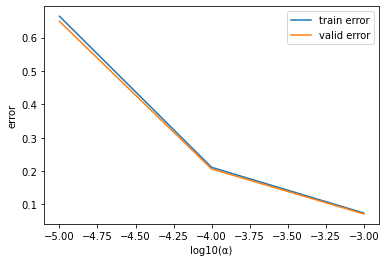

In [39]:
# 绘制error曲线
x = [1e-3,1e-4, 1e-5]
x = [math.log10(i) for i in x]
plt.plot(x, train_error1, x, valid_error1)
plt.xlabel("log10(α)")  # x轴上的名字
plt.ylabel("error")  # y轴上的名字
plt.legend(['train error', 'valid error'])
# new_ticks = np.linspace(0, 95000, 20)
# plt.xticks(new_ticks)
plt.show()

From the above figure, when stepsize is selected as 0.001, the error is lower.

#### 三、Train the model
The complete two-layer neural network classifier after the parameters are determined:

Learning rate: 0.001

Hidden layer size: 140

Regularization Strength: 0.032

minibatch: 32

After training, save the training results.

In [15]:
def count_loss(X, w1, w2, y, lambd):
    h = 1.0 / (1.0 + np.exp(-X.dot(w1)))  # 激活函数
    y_pred = h.dot(w2)
    loss = np.square(y_pred-y).sum()
    # L2正则化
    L2_regularization_cost = lambd * (np.sum(np.square(w1)) + np.sum(np.square(w2)))
    loss = loss + L2_regularization_cost  # loss计算
    return loss
    
if __name__ == "__main__":
    random.seed(1)
    np.random.seed(1)
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)  # MNIST_data指的是存放数据的文件夹路径，one_hot=True 为采用one_hot的编码方式编码标签
    # load data
    Xtrain = mnist.train.images  # 训练集样本
    Xvalid = mnist.validation.images  # 验证集样本
    Xtest = mnist.test.images  # 测试集样本
    # labels
    Ytrain = mnist.train.labels  # 训练集标签
    Yvalid = mnist.validation.labels  # 验证集标签
    Ytest = mnist.test.labels  # 测试集标签

    # shape参数
    n, d = Xtrain.shape
    t = Xvalid.shape[0]
    t2 = Xtest.shape[0]

    # 添加偏置项
    Xtrain = np.c_[np.ones(n), Xtrain]
    d = d + 1
    Xvalid = np.c_[np.ones(t), Xvalid]
    Xtest = np.c_[np.ones(t2), Xtest]

    # nLabels
    nLabels = 10

    # Choose network structure
    nHidden = np.array([140])

    # Count number of parameters and initialize weights 'w'
    nParams = d * nHidden  # 参数数目
    for h in range(1, len(nHidden)):
        nParams = nParams + nHidden[h - 1] * nHidden[h]
    nParams = nParams + nHidden[-1] * nLabels
    
    # 随机确定初始w
    w1 = randn(d, nHidden[0])
    w2 = randn(nHidden[0], nLabels)

    # Train with stochastic gradient
    maxIter = 100000
    stepSize = 0.001
    minibatch = 32
    lamda = 0.032
    gama = 0.9
    train_accuracy = []
    valid_accuracy = []
    train_loss = []
    valid_loss = []
    for iter in range(maxIter):
        if iter % round(maxIter / 20) == 0:
            yhat_train = predict(Xtrain, w1, w2)
            yhat_valid = predict(Xvalid, w1, w2)
            error1 = (yhat_train != Ytrain).sum() / n / 2.0
            error2 = (yhat_valid != Yvalid).sum() / t / 2.0
            train_accuracy.append(1-error1)
            valid_accuracy.append(1-error1)
            # 计算loss
            valid_loss.append(count_loss(Xvalid, w1, w2, Yvalid, lamda))
            
            train_loss.append(count_loss(Xtrain, w1, w2, Ytrain, lamda)) 
            stepSize = stepSize * gama  # 学习率下降策略
            
        # 优化器SGD
        i = [math.floor(random.random() * n) for k in range(minibatch)]
        l, dw1, dw2 = loss_L2(Xtrain[i], w1, w2, Ytrain[i], lamda)
        w1 = w1 - stepSize * dw1
        w2 = w2 - stepSize * dw2
        

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [25]:
import pickle
file = open('w1.pickle', 'wb')
pickle.dump(w1, file)
file.close()
file = open('w2.pickle', 'wb')
pickle.dump(w2, file)
file.close()

#### 四、Test Results
Visualize loss curves for training and testing, accuracy curves for testing, and visualize network parameters for each layer.

It can be seen that on the test set, the correct rate of the classifier can reach 0.9262, indicating that the classifier works well.

In [16]:
# Evaluate test error
yhat = predict(Xtest, w1, w2)
print('the accuracy of the final model on test = {}'.format(1-((yhat != Ytest).sum() / t2 / 2.0)))

the accuracy of the final model on test = 0.9262


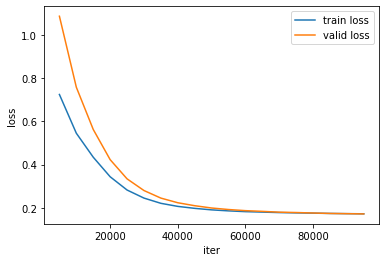

In [21]:
# loss曲线
x1 = range(5000,100000,5000)
train_loss1 = [i/n for i in train_loss]
valid_loss1 = [i/t for i in valid_loss]
plt.plot(x1, train_loss1[1:20], x1, valid_loss1[1:20])
plt.xlabel("iter")  # x轴上的名字
plt.ylabel("loss")  # y轴上的名字
plt.legend(['train loss', 'valid loss'])
plt.savefig("loss.jpg",dpi=300)
plt.show()

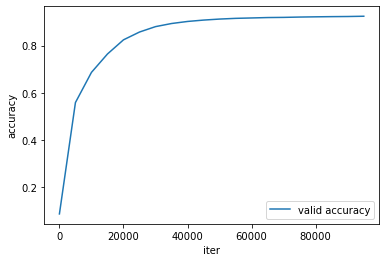

In [22]:
# accurate曲线
x2 = range(0,100000,5000)
plt.plot(x2, valid_accuracy)
plt.xlabel("iter")  # x轴上的名字
plt.ylabel("accuracy")  # y轴上的名字
plt.legend(['valid accuracy'])
plt.savefig("accuracy.jpg",dpi=300)
plt.show()

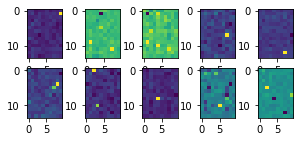

In [30]:
# 可视化参数w2
import cv2
from PIL import Image
q, p = w2.shape
plt.figure(figsize=(5,2))
for i in range(p):
    plt.subplot(2,5,i+1)
    plt.imshow(w2[:,i].reshape(14,10))


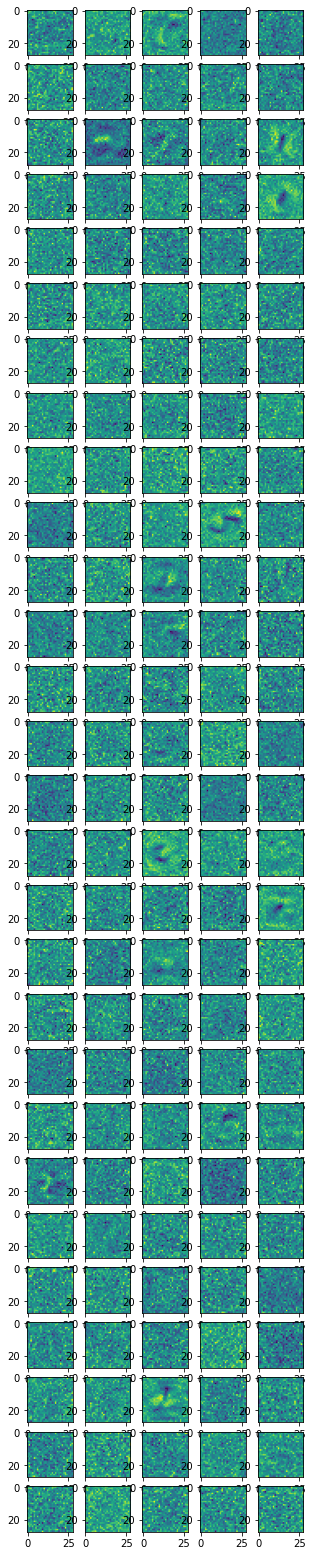

In [31]:
# 可视化参数w1
q1, p1 = w1.shape
plt.figure(figsize=(5,28))
for i in range(p1):
    plt.subplot(28,5,i+1)
    plt.imshow(w1[1:q1,i].reshape(28,28))
    

#### 五、github链接及网盘链接
github repo链接：

https://github.com/eveyaohuijia/DATA130051.01-hw1

模型网盘下载地址；

链接: https://pan.baidu.com/s/1Xg7EMjdVBZU4nSicHJva8g 提取码: i4zt 复制这段内容后打开百度网盘手机App，操作更方便哦